---
# ResNet - Residual Network Model
----

### Summary:
In this notebook, we will build and use ResNet-50 model to analyse and interpret the features learned from the MNIST Sign Language Dataset.

ResNet-50 is a pre-defined CNN, trained on a very large image dataset (ImageNet). We will use features the model has learned from training and apply them to our dataset. This process is called Transfer Learning.

The purpose of using pre-trained models like ResNet is due to their exposure to diverse images which enables them to capture a broader range of features. ResNet's architecture includes skip connections which help mitigate the vanishing gradient problem, allowing the training of very deep networks.

### Data Overview:
- **Dataset:** MNIST Sign Language Dataset
- **Number of Samples:** Approximately 1400 images per character
- **Image Dimensions:** Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:

- **Data Loading:**
    - Load the MNIST Sign Language dataset.
    - Split data into training and validation datasets.
    - Scale X.

- **Defining the ResNet-50 Model:**
    - Construct the ResNet-50 model architecture.
    - Define input layers, residual blocks, and fully connected layers.

- **Training the ResNet-50 Model:**
    - Compile the model with loss function and optimiser.
    - Train the ResNet-50 model on the training data and validate its performance on the validation dataset.

- **Model Evaluation:**
    - Evaluate the accuracy of the trained ResNet-50 model on the validation dataset.
    - Analyse the model's performance using a confusion matrix and visualise the misclassifications.

## Set Up
----

In [38]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import random

In [2]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

## Utility Functions
-----

In [3]:
def img_resize(X_data, new_height, new_width, rgb= True):
    '''
        Overview:
        To resize input images to match network input layer.

        Arguments:
            - X_data: CNN model to inspect
            - new_height: input layer height
            - new_width: input layer width
            - rgb = True as default (RGB channels to 3 as default)

        Output:
            - Resized X_data
    '''
    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Data Loading
----

In [ ]:
X = joblib.load( '../../data/my_data/X.pkl')
y = joblib.load( '../../data/my_data/y.pkl')


In [ ]:
X = X.reshape(-1,28,28)
X.shape

### Train/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

### Scaling X

In [ ]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

In [40]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

## Defining ResNet-50 Architecture
---

In [5]:
from tensorflow.keras.applications import ResNet50V2

res_model = keras.applications.ResNet50V2(include_top=False, # Set to false to only load the conv layers, will be swapping out the top layers for own
                                     weights='imagenet', 
                                     input_tensor=None,
                                     input_shape=(64,64,3) ,# changing input shape to (64,64,3) 
                                     pooling=max, # for my output will use pooling
                                     classes= 24, # setting to len of my y (24)
                                     classifier_activation='softmax' # keep as softmax for output layer
                                 )

In [7]:
# Using pre-learnt weights
res_model.trainable = False

### Adding own top layers

In [8]:
my_model = Sequential([res_model,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(24, activation="softmax")
                       ])

In [9]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
Total params: 24,623,320
Trainable params: 1,058,520
Non-trainable params: 23,564,800
_________________________________________________________________


### Compiling the model

In [10]:
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [11]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])

## Train model using the original MNIST data
---

In [27]:
# Resize data to fit input shape of resnet 50
X_train_resized = img_resize(X_train, 64, 64)
X_val_resized = img_resize(X_val, 64, 64)

In [28]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)


In [29]:
history = my_model.fit(X_train_resized, y_train,
                        batch_size = 128,
                        epochs = 50, # higher than VGG as ResNet is a deeper network and learning rate is higher
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/50


2024-07-07 12:59:09.077961: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


174/174 [==============================] - 77s 438ms/step - loss: 0.4054 - accuracy: 0.9023 - val_loss: 0.0251 - val_accuracy: 0.9977
Epoch 2/50
174/174 [==============================] - 77s 445ms/step - loss: 0.0118 - accuracy: 0.9995 - val_loss: 0.0086 - val_accuracy: 0.9991
Epoch 3/50
174/174 [==============================] - 78s 449ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9996
Epoch 4/50
174/174 [==============================] - 73s 418ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9996
Epoch 5/50
174/174 [==============================] - 81s 464ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9996
Epoch 6/50
174/174 [==============================] - 81s 466ms/step - loss: 7.6593e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/50
174/174 [==============================] - 80s 461ms/step - loss: 5.6428e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accur

### Saving the model

In [30]:
my_model.save('../../model/my_models/ResNet_model.h5')

### Assessing training and validation scores

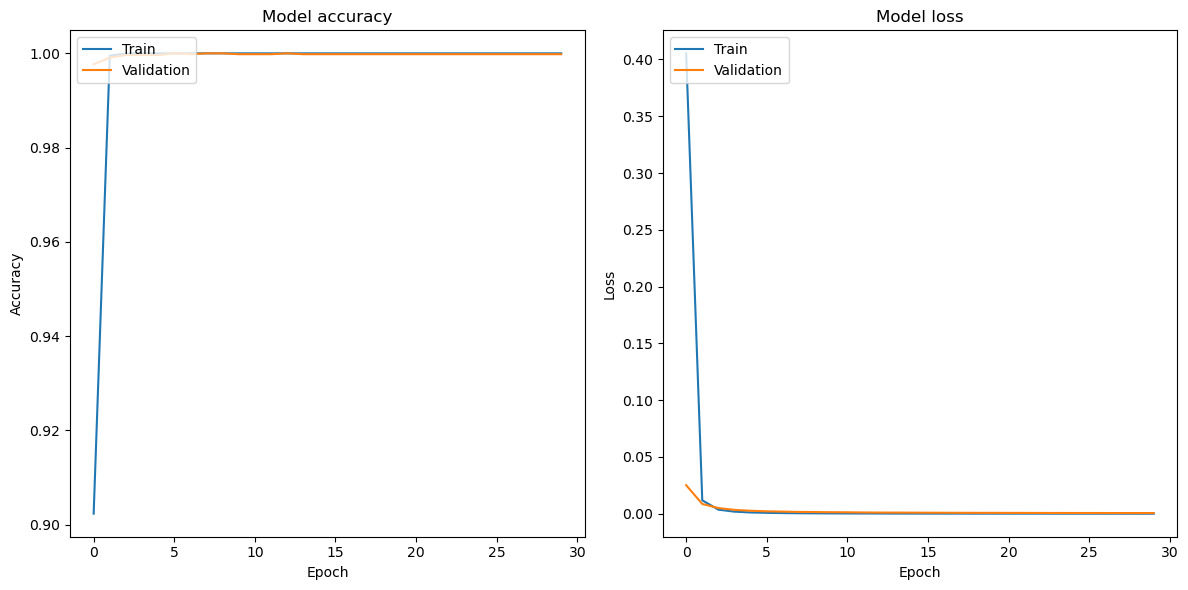

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**Comment:**

Significant imporvement after the first epoch in the accuracy score and loss indicating. 

For the following epochs we see less of a dramatic increase in performance, perhaps I set the learning rate to be too low - this will be something to test using Keras Bayesian Optimiser at a later date to find the optimum params.

In addition to this, I could also look into applying some form regularisation to the network.

In [57]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train)
print('Train accuracy:', train_acc)

866/866 [==============================] - 178s 204ms/step - loss: 1.2996e-04 - accuracy: 1.0000
Train accuracy: 0.9999638795852661


In [33]:
print(f'ResNet model Training Score: {round(train_acc*100,4)}')

ResNet model Training Score: 99.9964


In [34]:
val_loss, val_acc = my_model.evaluate(X_val_resized, y_val)
print('Val accuracy:', val_acc)

217/217 [==============================] - 19s 84ms/step - loss: 0.0026 - accuracy: 0.9988
Val accuracy: 0.9988449215888977


In [35]:
print(f'ResNet model Validation Score: {round(val_acc*100,4)}')

ResNet model Validation Score: 99.8845


## Model Evaluation
-----

In [54]:
resnet_model = load_model('../../model/my_models/ResNet_model.h5')

### Confusion Matrix

217/217 [==============================] - 64s 286ms/step


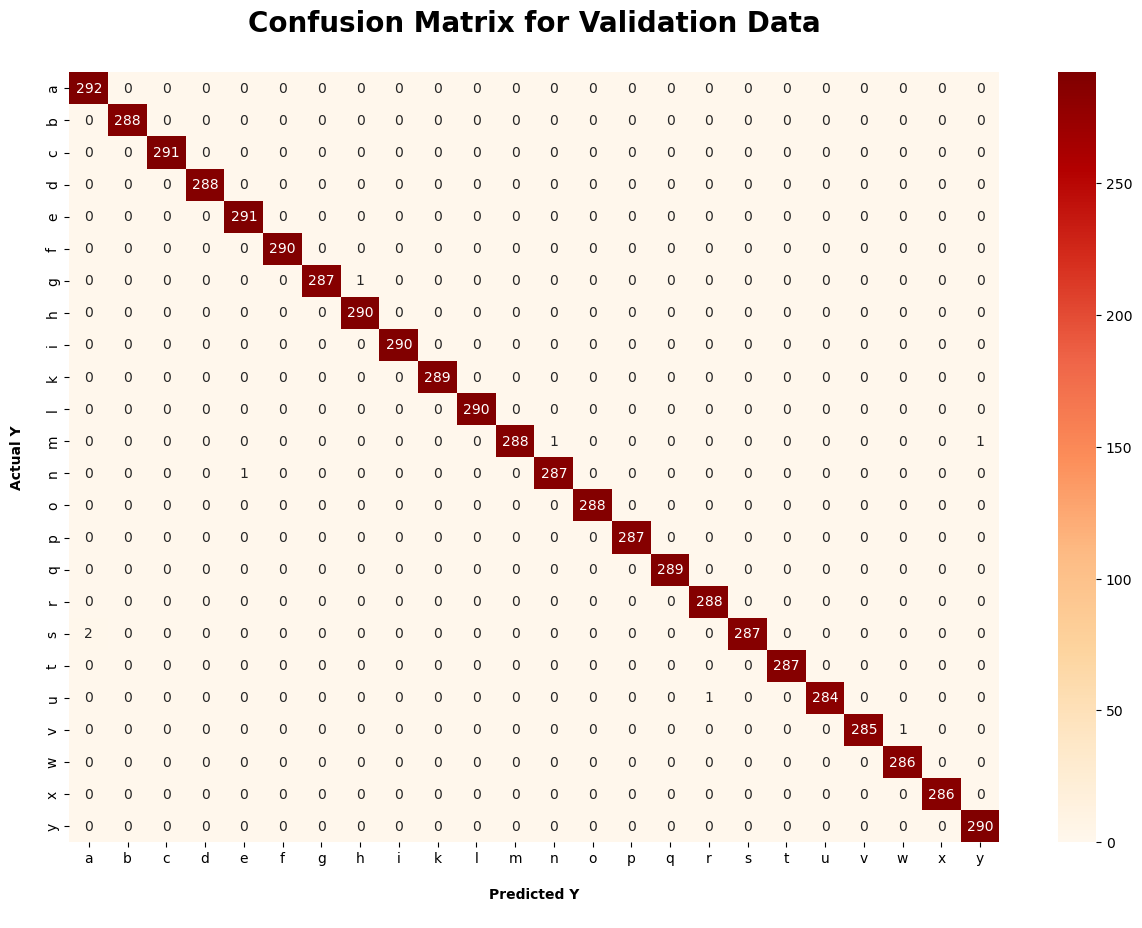

In [64]:
pred_y = np.argmax(resnet_model.predict(X_val_resized), axis=1)

conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Comment:**

Very few misclassifcations, likely due to poor hand positioning or lighting as the model has seemed to have learnt how to distinguish between the classes very well.

We can confirm this in the next part of the notebook.

### Visualising Misclassifications

In [65]:
incorrect_photos = (y_val != pred_y)

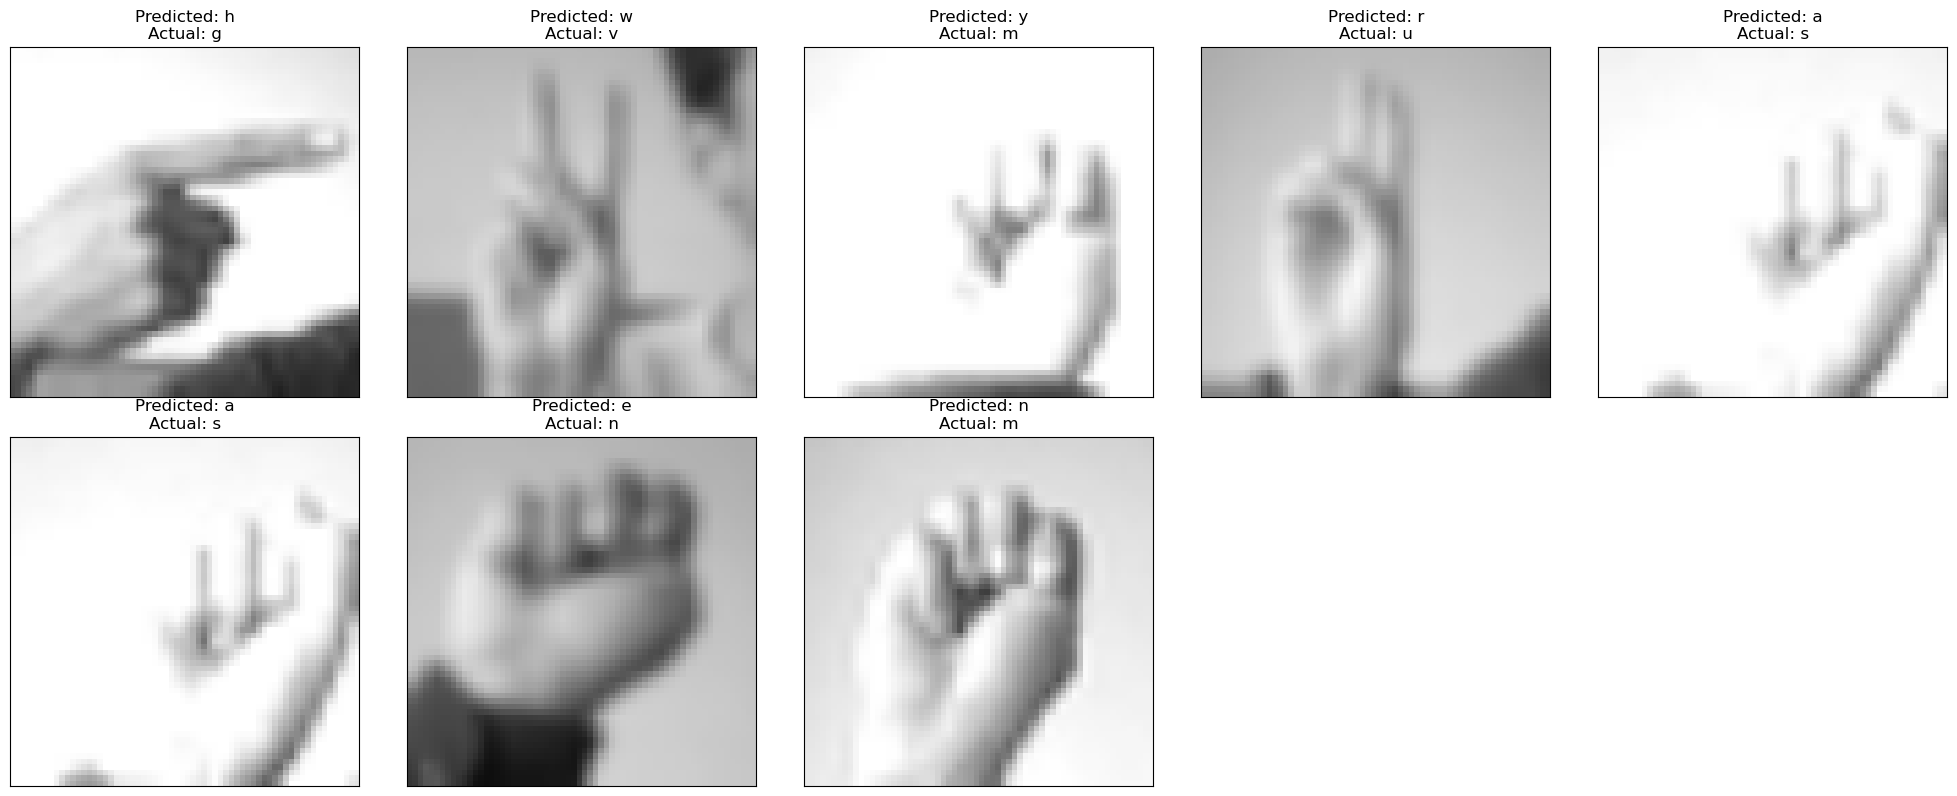

In [71]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

if num_photos == 0:
    print('There are no misclassifications to show!')
else:
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))

    for i, ax in enumerate(axes.flatten()):
        if i < num_photos:
            ax.imshow(X_val_resized[incorrect_photos][i], cmap='gray')

            # Get predicted label
            p = pred_y[incorrect_photos][i]
            prediction = alphabet[p]

            # Get actual label
            a = y_val[incorrect_photos][i]
            actual = alphabet[a.astype(np.int32)]

            # Set the title of the subplot
            ax.set_title(f"Predicted: {prediction}\nActual: {actual}")

            # Hide the x and y ticks
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)  # Delete unused subplots

    plt.tight_layout()
    plt.show()

**Comment:**

As suspecteted, most of these misclassifications are cases where the lighting conditions are poor (too bright) and a few cases where the background is not clear. Both can cause the model to get confused leading to misclassifications

### Testing an Unseen Input Image

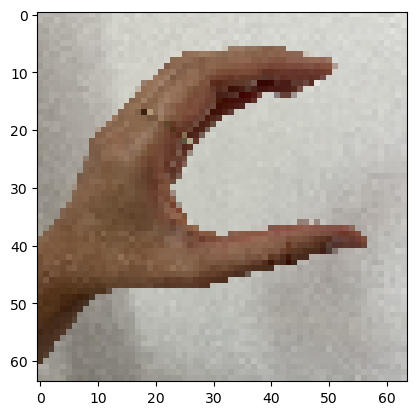

In [72]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(64, 64))
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)
plt.imshow(input_image) # checking image has correct orientation
plt.show()

In [73]:
image_array = img_to_array(input_image)
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [74]:
soft_pred = resnet_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 458ms/step


In [75]:
print(f'Prediction using ResNet: \n{alphabet[pred_y[0]].upper()}')

Prediction using ResNet: 
W


## Conclusion
-----

|                  | ResNet        |
|------------------|---------------|
| Train Score      | 99.99         |
| Validation Score | 99.88         |

The accuracy scores of ResNet model suggests the model has effectively learnt to distinguish between the letters. Similar to VGG, there is a small difference between the train and validation score also suggests the model is not overfitting and has learned to generalise well to unseen data. 

Moving forward, the model's ability to handle augmented data will be tested in order to validate the model's robustness.